# Sea Ice Extent Timeseries
## **SODA**

In [41]:
! mamba install "xgcm<0.7.0" -y


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.25.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ["xgcm[version='<0.7.0']"]

[+] 0.0s
conda-forge/linux-64 ━━━━━━━━━━━━━╸━━━━━━━━━   0.0 B /  ??.?MB

In [42]:
#load in autoreload so you don't have to restart kernel everytime you want to run bb function
%load_ext autoreload

#Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [56]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [22]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.310258fc3a7146b79ea1e3b88627b36a/status,


In [127]:
client.close()
cluster.close()

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
import xgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt

In [2]:
path = "s3://Pangeo/pangeo-forge/soda342/5day_ice.zarr"
mapper = fsspec.get_mapper(
    path, anon=True, client_kwargs={'endpoint_url': 'https://ncsa.osn.xsede.org'},
)
ds = xr.open_zarr(mapper, consolidated=True)

In [3]:
ds

<xarray.Dataset>
Dimensions:      (time: 2117, ct: 5, yt: 1070, xt: 1440, xv: 1440, yv: 1070,
                  nv: 2, xb: 1441, yb: 1071)
Coordinates:
  * ct           (ct) float64 0.0 0.1 0.3 0.7 1.1
  * nv           (nv) float64 1.0 2.0
  * time         (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00
  * xb           (xb) float64 -280.0 -279.8 -279.5 -279.3 ... 79.53 79.77 80.0
  * xt           (xt) float64 -279.9 -279.7 -279.4 -279.2 ... 79.42 79.65 79.88
  * xv           (xv) float64 -279.8 -279.5 -279.3 -279.1 ... 79.53 79.77 80.0
  * yb           (yb) float64 -80.07 -79.97 -79.86 -79.76 ... 78.84 78.85 78.85
  * yt           (yt) float64 -80.02 -79.92 -79.81 -79.7 ... 78.84 78.84 78.85
  * yv           (yv) float64 -79.97 -79.86 -79.76 -79.65 ... 78.84 78.85 78.85
Data variables:
    average_DT   (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T1   (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2   (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    cn           (time, ct, yt, xt) float32 dask.array<chunksize=(1, 5, 1070, 1440), meta=np.ndarray>
    hi           (time, yt, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    hs           (time, yt, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    ix_trans     (time, yt, xv) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    iy_trans     (time, yv, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    mi           (time, yt, xt) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    time_bounds  (time, nv) timedelta64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    ui           (time, yv, xv) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
    vi           (time, yv, xv) float32 dask.array<chunksize=(1, 1070, 1440), meta=np.ndarray>
Attributes:
    filename:   soda3.4.2_5dy_ice_or_1992_01_05.nc
    grid_tile:  1
    grid_type:  mosaic
    title:      MOM5_SODA_3.4.2

In [4]:
ds.cn

,Array,Chunk
Bytes,60.76 GiB,29.39 MiB
Shape,"(2117, 5, 1070, 1440)","(1, 5, 1070, 1440)"
Count,2 Graph Layers,2117 Chunks
Type,float32,numpy.ndarray


In [51]:
#WGxtoundaries (80˚S, 57˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 209 #right exclusive so it'll stop at -57.08949753
left_lon =  869 #-64.96
right_lon = 1228 #30.04

lower_lat_u = 0 #-79.96821565
upper_lat_u = 208 #-57.15741334
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [52]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [53]:
ice = ds.cn.isel(**lat_range_no_u, **lon_range_no_u)
#ds_wg = ds.isel(**lat_range, **lon_range)

In [54]:
ice

,Array,Chunk
Bytes,2.96 GiB,1.43 MiB
Shape,"(2117, 5, 209, 359)","(1, 5, 209, 359)"
Count,3 Graph Layers,2117 Chunks
Type,float32,numpy.ndarray


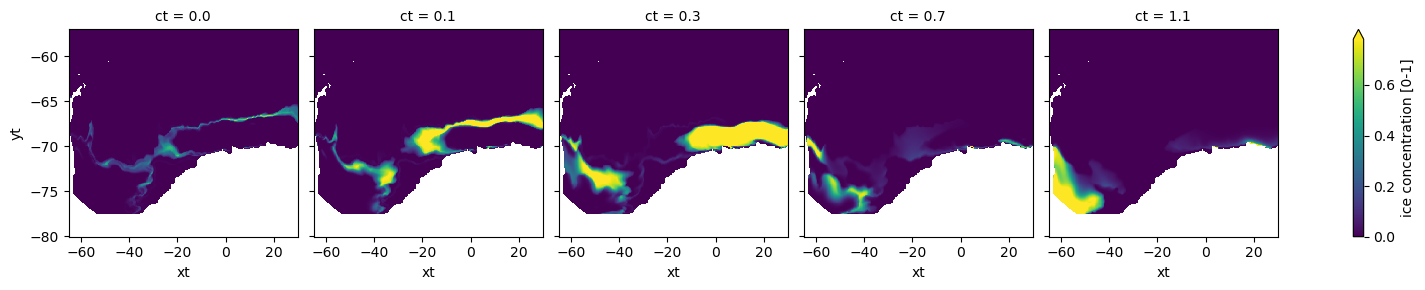

In [55]:
ice.isel(time=0,ct=[0,1,2,3,4]).plot(robust=True, col='ct');

In [57]:
#999 is ocean, 111 is land
mask = ice.where(ice == ice.notnull(), 999).where(ice < 999, 111)

In [58]:
mask

,Array,Chunk
Bytes,2.96 GiB,1.43 MiB
Shape,"(2117, 5, 209, 359)","(1, 5, 209, 359)"
Count,9 Graph Layers,2117 Chunks
Type,float32,numpy.ndarray


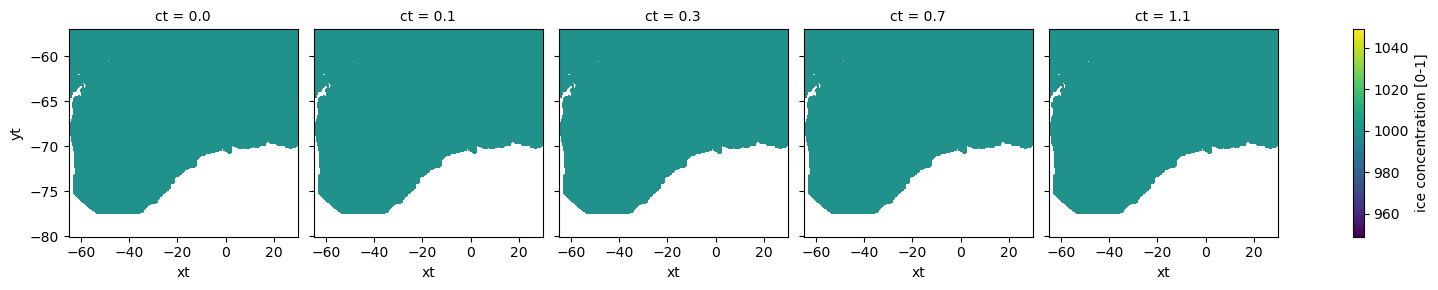

In [59]:
mask.where(mask == 999).isel(time=0,ct=[0,1,2,3,4]).plot(robust=True, col='ct');

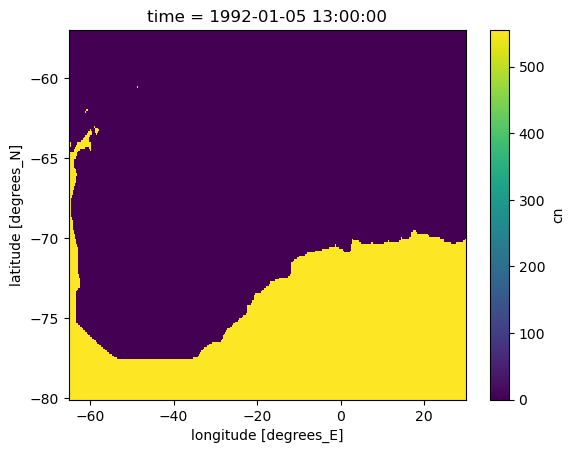

In [60]:
mask.where(mask == 111).sum('ct')[0].plot()

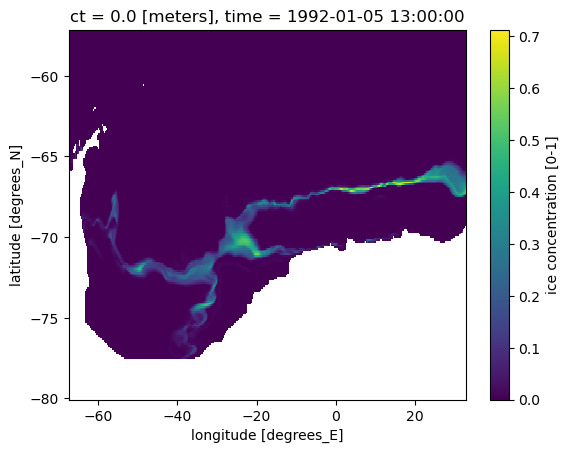

In [19]:
ice.where(mask == 999)[0,0].plot()

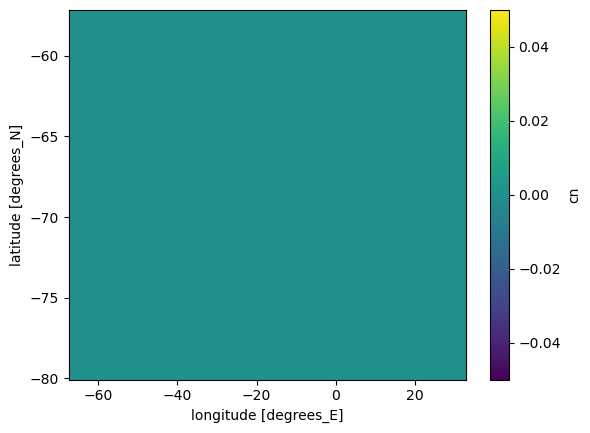

In [23]:
mask.where(mask == 111).sum('ct').std(dim='time').plot()

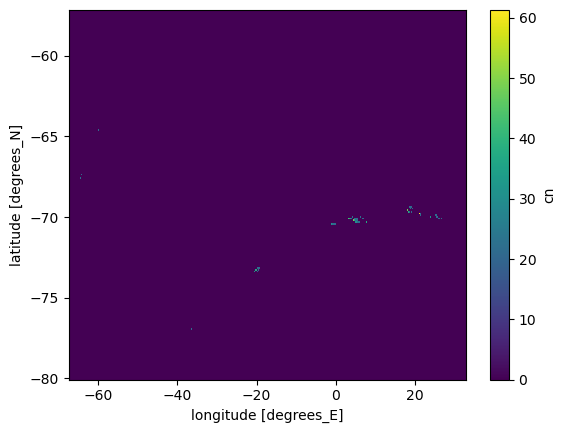

In [24]:
mask.where(mask == 999).sum('ct').std(dim='time').plot()

In [61]:
land = mask.where(mask == 999).sum('ct')[0]

In [26]:
land

<xarray.DataArray 'cn' (yt: 208, xt: 381)>
dask.array<getitem, shape=(208, 381), dtype=float32, chunksize=(208, 381), chunktype=numpy.ndarray>
Coordinates:
    time     object 1992-01-05 13:00:00
  * xt       (xt) float64 -67.34 -67.1 -66.87 -66.63 ... 31.99 32.24 32.48 32.72
  * yt       (yt) float64 -80.02 -79.92 -79.81 -79.7 ... -57.49 -57.36 -57.23

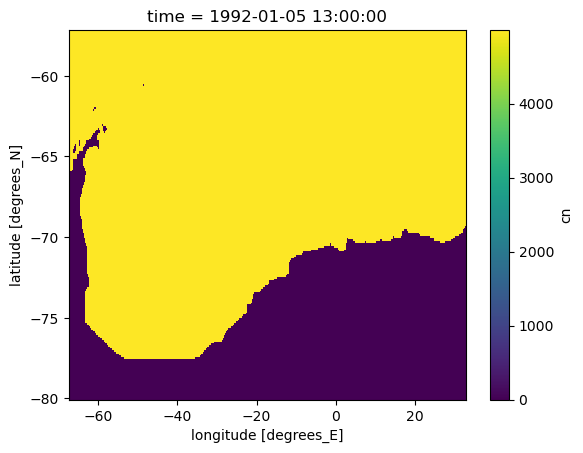

In [27]:
land.plot()

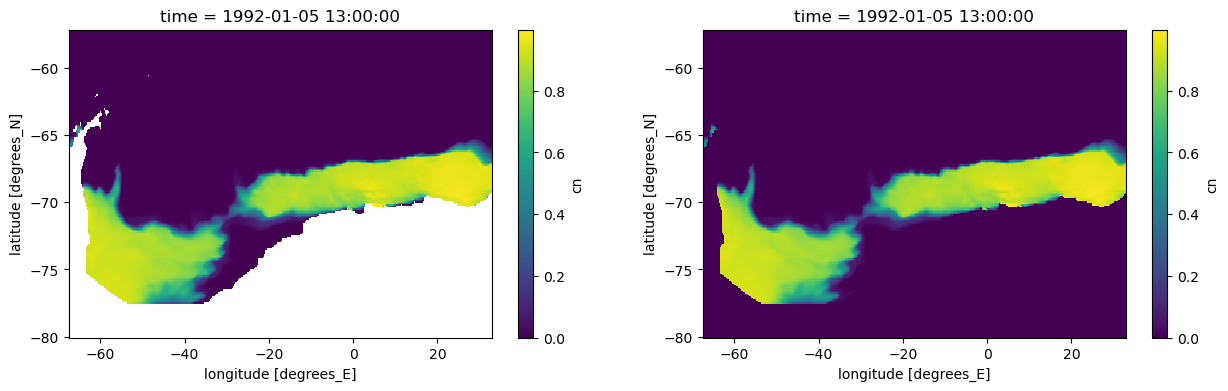

In [28]:
#values are slightly different with the mask. More yellow in plot without mask
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))

ice.sum('ct')[0].where(land).plot(ax=ax0)
ice.sum('ct')[0].plot(ax=ax1);

In [30]:
ice

,Array,Chunk
Bytes,3.12 GiB,1.51 MiB
Shape,"(2117, 5, 208, 381)","(1, 5, 208, 381)"
Count,3 Graph Layers,2117 Chunks
Type,float32,numpy.ndarray


In [64]:
import xgcm

grid = xgcm.Grid(ds, coords={'X': {'center': 'xt', 'left': 'xb'}, 
                              'Y': {'center': 'yt', 'left': 'yb'},
                              'T': {'center': 'time'}},
                      periodic=['X'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt --> left
  * left     xb --> center
Y Axis (not periodic, boundary=None):
  * center   yt --> left
  * left     yb --> center
T Axis (not periodic, boundary=None):
  * center   time

In [65]:
import xgcm

grid_ds = xgcm.Grid(ds, coords={'X': {'center': 'xt', 'left': 'xv'}, 
                              'Y': {'center': 'yt', 'left': 'yv'},
                              'T': {'center': 'time'}},
                      periodic=['X'])
grid_ds

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt --> left
  * left     xv --> center
Y Axis (not periodic, boundary=None):
  * center   yt --> left
  * left     yv --> center
T Axis (not periodic, boundary=None):
  * center   time

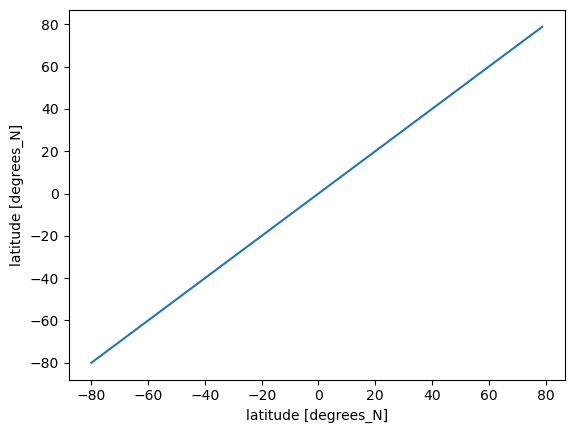

In [46]:
ds.yt.plot()

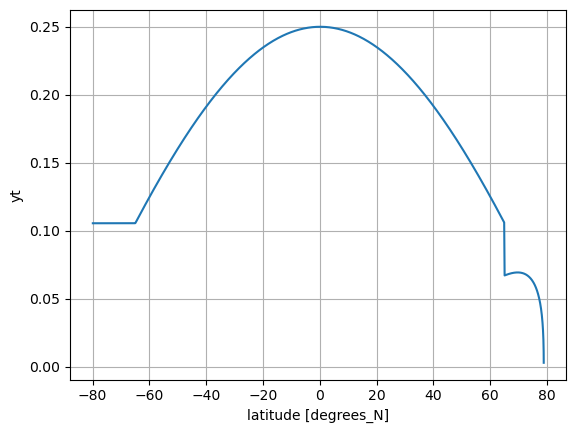

In [47]:
ds.yt.diff('yt').plot()
plt.grid()

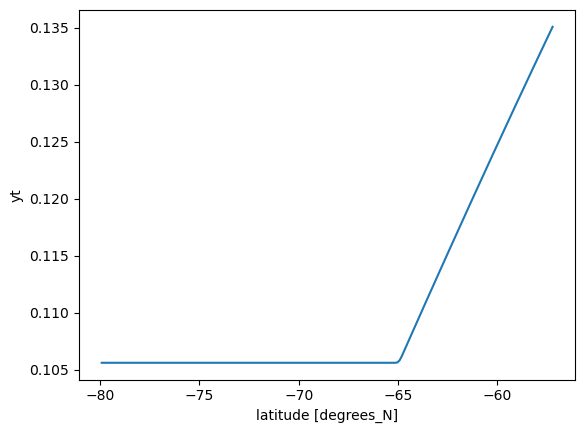

In [48]:
ice.yt.diff('yt').plot()

In [66]:
#calculating meters per latitudinal & longitudinal degree
earth_radius = 6.371e6
earth_circumference = 2*np.pi*earth_radius
meters_per_degree = earth_circumference / 360

#converting lat from degrees to meters
delta_lat = grid_ds.diff(ds.yt, 'Y', boundary='fill', fill_value=np.nan)
dy = delta_lat * meters_per_degree

#converting degrees lon to lon [meters] (pinching at the poles)
delta_lon = grid_ds.diff(ds.xt, 'X', boundary_discontinuity=360)
dx = delta_lon * meters_per_degree * np.cos(np.deg2rad(ds.yt))

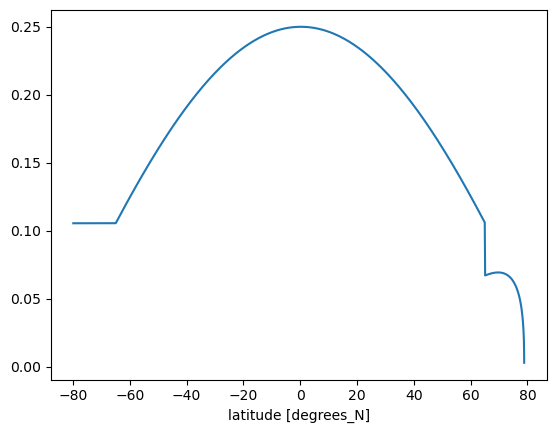

In [67]:
delta_lat.plot()

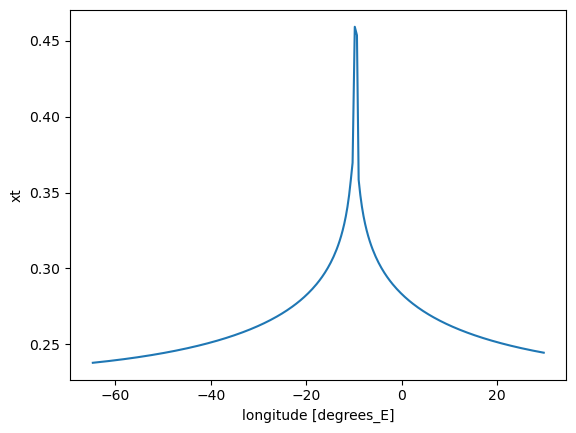

In [68]:
ice.xt.diff('xt').plot()

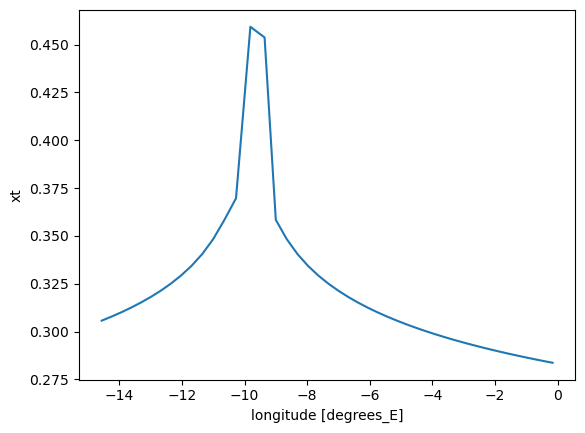

In [69]:
ice.xt.sel(xt=slice(-15,0)).diff('xt').plot()

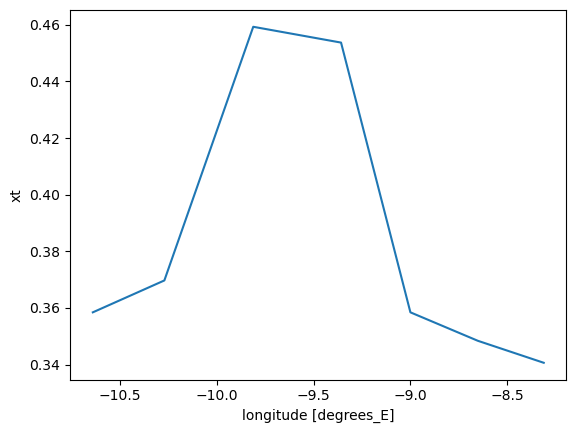

In [70]:
ice.xt.sel(xt=slice(-11,-8)).diff('xt').plot()

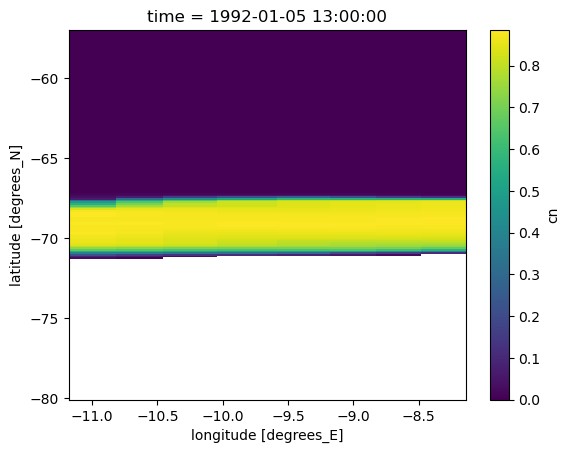

In [71]:
ice.sum('ct')[0].where(land).sel(xt=slice(-11,-8)).plot()

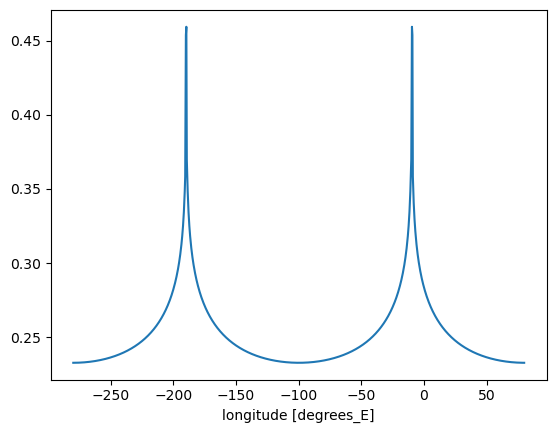

In [72]:
delta_lon.plot()

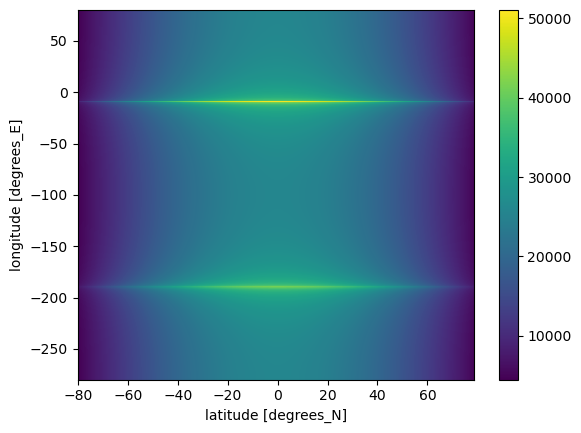

In [73]:
dx.plot()

In [74]:
dy_interp = grid_ds.interp(dy, 'Y', boundary='fill')
dx_interp = grid_ds.interp(dx, 'X')

In [75]:
dx_interp

<xarray.DataArray (xt: 1440, yt: 1070)>
array([[4483.89934483, 4530.86001734, 4577.8052994 , ..., 5008.91834396,
        5006.48219279, 5005.12768211],
       [4483.90724321, 4530.86799845, 4577.8133632 , ..., 5008.92716716,
        5006.4910117 , 5005.13649864],
       [4483.92304041, 4530.88396109, 4577.82949123, ..., 5008.94481405,
        5006.50865001, 5005.15413217],
       ...,
       [4483.92304042, 4530.88396109, 4577.82949124, ..., 5008.94481406,
        5006.50865001, 5005.15413218],
       [4483.90724322, 4530.86799845, 4577.8133632 , ..., 5008.92716717,
        5006.4910117 , 5005.13649864],
       [4483.89934483, 4530.86001734, 4577.8052994 , ..., 5008.91834396,
        5006.48219279, 5005.12768211]])
Coordinates:
  * xt       (xt) float64 -279.9 -279.7 -279.4 -279.2 ... 79.42 79.65 79.88
  * yt       (yt) float64 -80.02 -79.92 -79.81 -79.7 ... 78.83 78.84 78.84 78.85

In [76]:
dy_wg = dy_interp.isel(**lat_range_no_u)
dx_wg = dx_interp.isel(**lat_range_no_u, **lon_range_no_u)

In [77]:
dx_wg.coords

Coordinates:
  * xt       (xt) float64 -64.97 -64.73 -64.49 -64.25 ... 29.06 29.31 29.55 29.8
  * yt       (yt) float64 -80.02 -79.92 -79.81 -79.7 ... -57.36 -57.23 -57.09

In [78]:
ice.coords

Coordinates:
  * ct       (ct) float64 0.0 0.1 0.3 0.7 1.1
  * time     (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00
  * xt       (xt) float64 -64.97 -64.73 -64.49 -64.25 ... 29.06 29.31 29.55 29.8
  * yt       (yt) float64 -80.02 -79.92 -79.81 -79.7 ... -57.36 -57.23 -57.09

In [79]:
dy_wg.coords

Coordinates:
  * yt       (yt) float64 -80.02 -79.92 -79.81 -79.7 ... -57.36 -57.23 -57.09

In [80]:
weighted_ice = ice * dx_wg * dy_wg

In [81]:
msi = ice.sum('ct').mean(dim='time').load()
msi_weighted = weighted_ice.sum('ct').mean(dim='time').load()

In [82]:
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


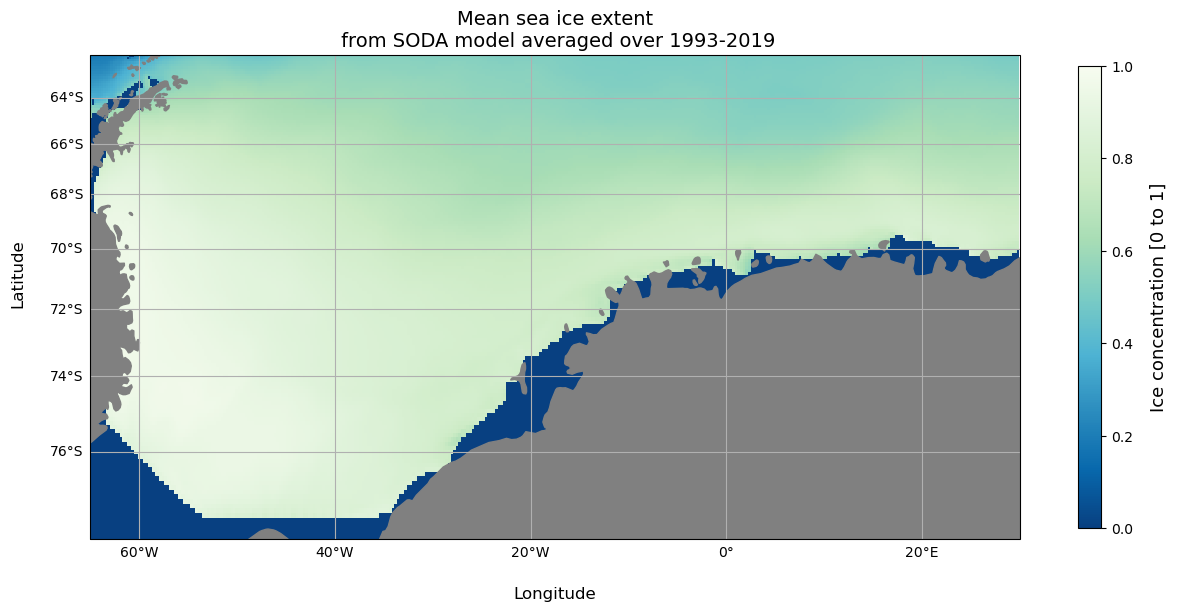

In [83]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ice.xt, ice.yt, msi, transform=ccrs.PlateCarree(), cmap='GnBu_r', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Ice concentration [0 to 1]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Mean sea ice extent\n from SODA model averaged over 1993-2019', fontsize=14);

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


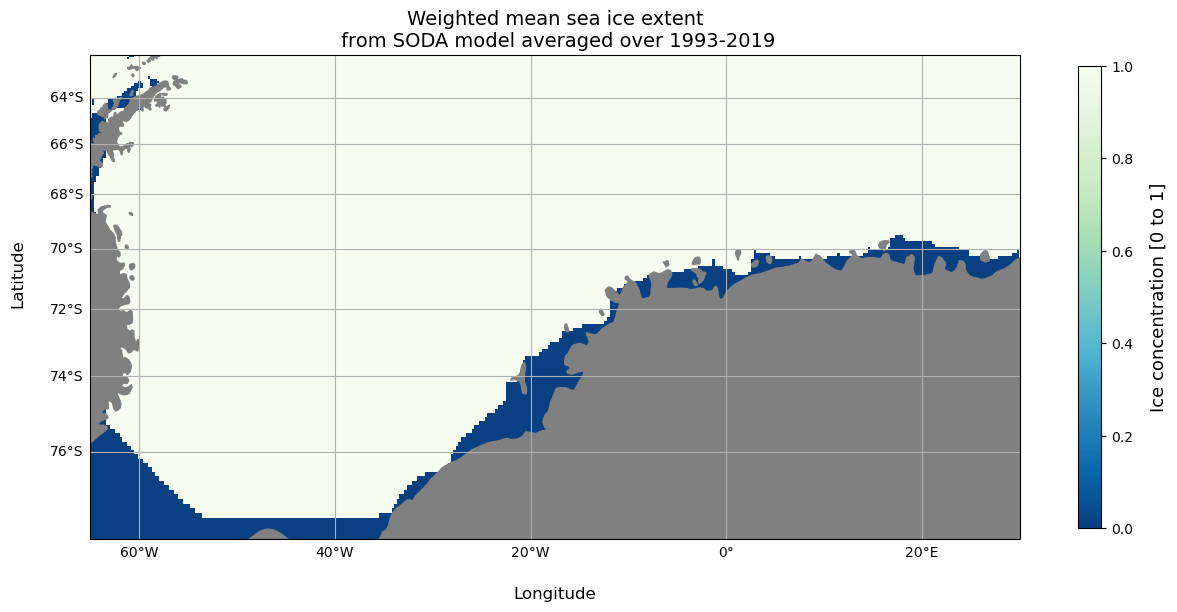

In [85]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ice.xt, ice.yt, msi_weighted, transform=ccrs.PlateCarree(), cmap='GnBu_r', vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Ice concentration [0 to 1]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Weighted mean sea ice extent\n from SODA model averaged over 1993-2019', fontsize=14);

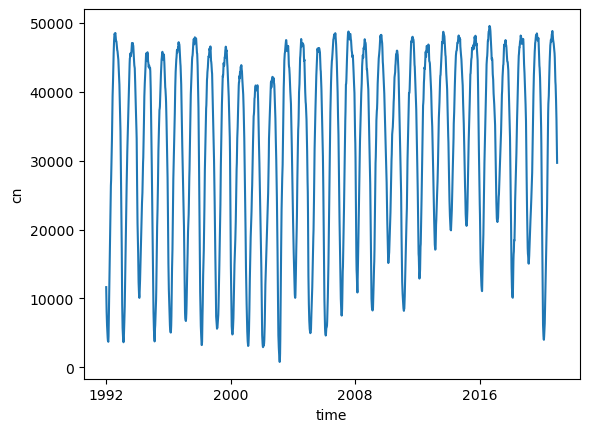

In [86]:
ice.sum(['ct', 'yt', 'xt']).plot();

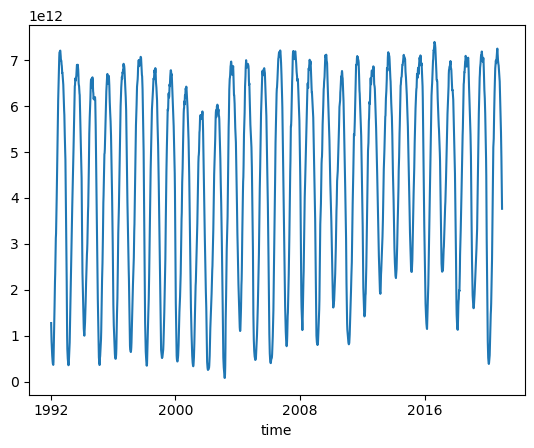

In [87]:
weighted_ice.sum(['ct', 'yt', 'xt']).plot();

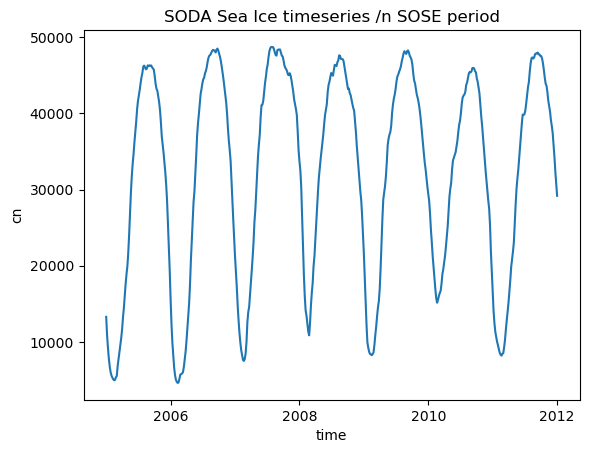

In [88]:
ice.sum(['ct', 'yt', 'xt']).sel(time=slice('2005', '2011')).plot()
plt.title('SODA Sea Ice timeseries /n SOSE period');

In [89]:
weighted_ice

,Array,Chunk
Bytes,5.92 GiB,2.86 MiB
Shape,"(2117, 5, 209, 359)","(1, 5, 209, 359)"
Count,7 Graph Layers,2117 Chunks
Type,float64,numpy.ndarray


In [90]:
ice_anom = weighted_ice.groupby('time.month') - weighted_ice.groupby('time.month').mean()
ice_anom

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 29 times more chunks
  return self.array[key]


,Array,Chunk
Bytes,5.92 GiB,2.86 MiB
Shape,"(2117, 5, 209, 359)","(1, 5, 209, 359)"
Count,102 Graph Layers,2117 Chunks
Type,float64,numpy.ndarray


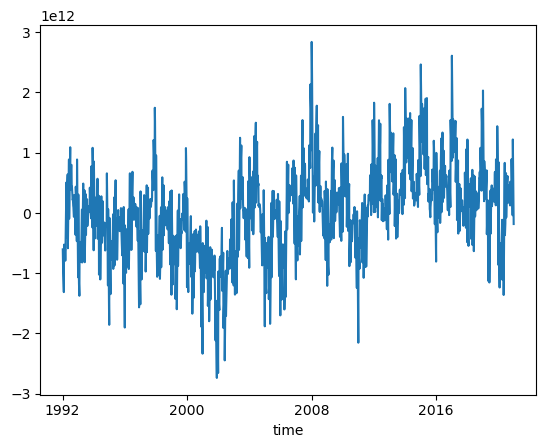

In [91]:
ice_anom.sum(['yt', 'xt', 'ct']).plot()

In [92]:
si_index = ice_anom.sum(['yt', 'xt', 'ct'])/ ice_anom.sum(['yt', 'xt', 'ct']).std(dim='time')
si_index

<xarray.DataArray (time: 2117)>
dask.array<truediv, shape=(2117,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00
    month    (time) int64 1 1 1 1 1 1 2 2 2 2 ... 11 11 11 11 11 12 12 12 12 12

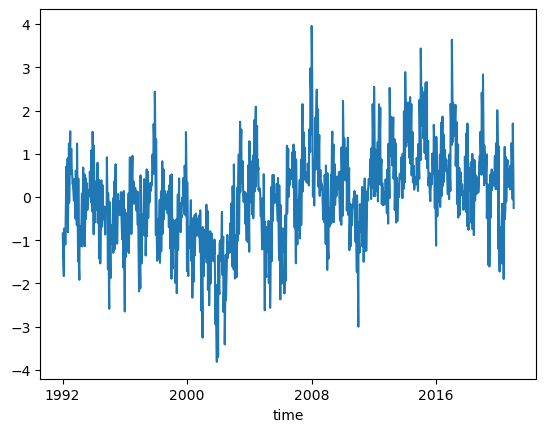

In [93]:
si_index.plot()

## SAM Index

In [67]:
url_ann = 'https://raw.githubusercontent.com/ocean-transport/WMT-project/master/SAM-index/ann-seas-sam-57-07.csv'
ann_seas = pd.read_csv(url_ann, delim_whitespace=True, parse_dates=True, )
url_mo = 'https://raw.githubusercontent.com/ocean-transport/WMT-project/master/SAM-index/mo-sam-57-07.csv'
mo = pd.read_csv(url_mo, delim_whitespace=True, parse_dates=True)

In [68]:
ann_seas.index = ann_seas.index.rename('time')
mo.index = mo.index.rename('time')

In [69]:
mo

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
time,,,,,,,,,,,,
1957-01-01,-0.87,-2.27,0.07,-1.97,-2.50,-0.87,1.00,-1.73,0.72,-3.12,-5.42,-2.63
1958-01-01,0.04,-2.84,-2.52,-0.30,-2.72,-0.97,-1.65,0.97,1.90,-0.16,0.30,0.82
1959-01-01,1.59,-0.19,-0.54,-1.25,-0.32,-1.12,0.18,-1.64,2.46,-0.46,3.28,-0.38
1960-01-01,0.90,0.85,3.40,-0.35,-0.60,-0.17,0.31,0.43,1.41,-1.17,1.18,1.36
1961-01-01,0.91,-4.00,-0.40,-0.14,1.12,-0.40,0.98,1.10,-1.21,1.64,1.52,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,-1.12,-1.09,-1.56,1.65,1.82,1.98,0.16,0.31,0.42,-0.64,3.18,1.44
2018-01-01,2.72,1.02,-0.03,-1.66,0.01,-1.57,0.55,-0.78,1.83,2.76,2.84,1.44
2019-01-01,2.79,-1.87,1.47,0.86,-0.11,2.21,-2.20,-2.04,0.81,-1.97,-4.42,-1.78


In [70]:
#flattening dataframe by having next row go after the prev row, instead of col going after col
time = pd.date_range('1/1957', '1/2022', freq='M')
vector = np.array(mo.iloc[0])
for i in range(1,65):
    new_vec = np.array(mo.iloc[i])
    vector = np.append(vector,new_vec)

In [71]:
mo_xr = xr.DataArray(vector, coords=[time.rename('time')])

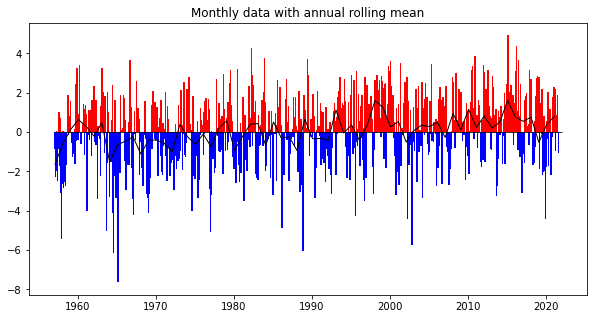

In [72]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.bar(time[np.where(mo_xr<0)], mo_xr.where(mo_xr < 0).dropna(dim='time'), color='b', width=70)
ax.bar(time[np.where(mo_xr>=0)], mo_xr.where(mo_xr >= 0).dropna(dim='time'), color='r', width=70)
ax.hlines(0, time[0], time[-1], colors='k', linewidth=0.8)
#mo_xr.rolling(time=12).mean().plot(color='k', linewidth=1)
plt.plot(time.values[np.arange(0, 780, 12)], mo_xr.groupby('time.year').mean().values, color='k', linewidth=1)
#mo_xr.groupby('time.year').mean().plot(color='k', linewidth=1)
plt.title('Monthly data with annual rolling mean');

## SAM & sea ice corr

In [73]:
ice.sum(['ct', 'yt', 'xt'])

<xarray.DataArray 'cn' (time: 2117)>
dask.array<sum-aggregate, shape=(2117,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00

In [74]:
ice.sum(['ct', 'yt', 'xt']).groupby('time.year').mean()

<xarray.DataArray 'cn' (year: 29)>
dask.array<stack, shape=(29,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1992 1993 1994 1995 1996 ... 2016 2017 2018 2019 2020

In [75]:
ann_seas.ANN.loc['1992':'2020']

time
1992-01-01   -0.96
1993-01-01    3.28
1994-01-01   -0.29
1995-01-01    1.19
1996-01-01   -1.04
1997-01-01    1.16
1998-01-01    4.46
1999-01-01    3.67
2000-01-01    0.26
2001-01-01    1.57
2002-01-01   -1.32
2003-01-01    0.35
2004-01-01    1.17
2005-01-01    0.30
2006-01-01    1.51
2007-01-01   -0.77
2008-01-01    2.28
2009-01-01    0.22
2010-01-01    3.28
2011-01-01    0.79
2012-01-01    2.11
2013-01-01    0.30
2014-01-01    1.31
2015-01-01    4.13
2016-01-01    1.67
2017-01-01    1.67
2018-01-01    1.96
2019-01-01   -1.50
2020-01-01    1.03
Name: ANN, dtype: float64

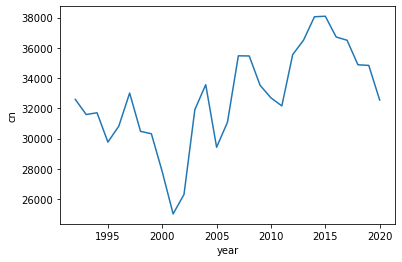

In [76]:
ice.sum(['ct', 'yt', 'xt']).groupby('time.year').mean().plot()

In [77]:
ann_xr = ann_seas.ANN.to_xarray()

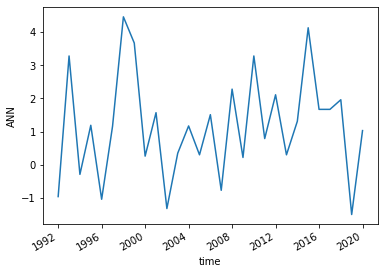

In [78]:
ann_xr.sel(time=slice('1992', '2020')).plot()

In [79]:
#changing SODA's SI timestamp to mo_xr timestamp
ice_ann = ice.sum(['ct', 'yt', 'xt']).groupby('time.year').mean().to_dataset().assign_coords(
                                time=ann_xr.time.sel(time=slice('1992', '2020')))#.drop('year')
ice_ann = ice_ann.cn.swap_dims({'year':'time'})
ice_ann

<xarray.DataArray 'cn' (time: 29)>
dask.array<stack, shape=(29,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    year     (time) int64 1992 1993 1994 1995 1996 ... 2016 2017 2018 2019 2020
Dimensions without coordinates: time

In [80]:
ann_xr.sel(time=slice('1992', '2020'))

<xarray.DataArray 'ANN' (time: 29)>
array([-0.96,  3.28, -0.29,  1.19, -1.04,  1.16,  4.46,  3.67,  0.26,
        1.57, -1.32,  0.35,  1.17,  0.3 ,  1.51, -0.77,  2.28,  0.22,
        3.28,  0.79,  2.11,  0.3 ,  1.31,  4.13,  1.67,  1.67,  1.96,
       -1.5 ,  1.03])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1993-01-01 ... 2020-01-01

In [81]:
corr_ice_ann = xr.corr(ice_ann, ann_xr.sel(time=slice('1992', '2020')), dim='time').values
corr_ice_ann

array(0.16115106)

In [82]:
ice.sum(['ct', 'xt', 'yt'])

<xarray.DataArray 'cn' (time: 2117)>
dask.array<sum-aggregate, shape=(2117,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00

In [83]:
corr_ann = xr.corr(ice.sum(['ct', 'xt', 'yt']), ann_xr.sel(time=slice('1992', '2020')), dim='time').values
corr_ann

array(nan)

In [84]:
corr_mo = xr.corr(ice.sum(['ct', 'xt', 'yt']), mo_xr.sel(time=slice('1992', '2020')), dim='time').values
corr_mo

array(nan)

## Saving Data

In [94]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [95]:
seaice_file = ice.to_dataset(name='seaice')

In [96]:
seaice_file

,Array,Chunk
Bytes,2.96 GiB,1.43 MiB
Shape,"(2117, 5, 209, 359)","(1, 5, 209, 359)"
Count,3 Graph Layers,2117 Chunks
Type,float32,numpy.ndarray


In [97]:
si_index_ds = si_index.to_dataset(name='soda_si_index')
si_index_ds

<xarray.Dataset>
Dimensions:        (time: 2117)
Coordinates:
  * time           (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00
    month          (time) int64 1 1 1 1 1 1 2 2 2 ... 11 11 11 11 12 12 12 12 12
Data variables:
    soda_si_index  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [98]:
#uploading wg region ice variable
gcsmap_seaice = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SODA/seaice.zarr')
seaice_file.to_zarr(gcsmap_seaice, mode='w')

In [ ]:
#uploading ecco seaice index 
gcsmap_si_index = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/models/SODA/soda_si_index.zarr')
si_index_ds.to_zarr(gcsmap_si_index, mode='w')

## Timeseries

In [3]:
soda = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/soda_si_index.zarr'))
sam = xr.open_dataarray('/home/jovyan/WMT-project/Climate-Indices/SAM-index/sam_mo_anom')
enso = xr.open_dataarray('/home/jovyan/WMT-project/Climate-Indices/ENSO-index/oni')

In [4]:
soda_greg_cal = soda.soda_si_index.resample(time='MS').mean().assign_coords(
                                            coords={'time':enso.sel(time=slice('1992', '2020')).time}).load()
soda_greg_cal

<xarray.DataArray 'soda_si_index' (time: 348)>
array([-1.33993147e+00, -7.94785503e-01, -2.03644555e-01,  2.05115862e-01,
        1.59171354e-01,  7.22375902e-01,  1.17427687e+00,  9.94714389e-01,
        4.35942469e-01,  3.70856318e-01,  1.15204196e-01, -9.42693026e-02,
       -1.05757156e+00, -7.88776431e-01, -5.30667292e-01, -2.31468741e-01,
       -1.94348719e-01, -3.87662078e-01, -8.76037448e-02, -1.39524222e-01,
       -2.80864383e-02, -1.95069978e-01,  1.57666752e-01,  5.34650854e-01,
        2.59702776e-01,  1.10542891e-01,  1.71729629e-01, -7.67074516e-02,
       -6.21807893e-01, -4.29820096e-01, -2.37292101e-01, -3.81615496e-01,
       -6.64409468e-01, -6.53847291e-01, -4.83944787e-01, -1.26323514e+00,
       -1.05956994e+00, -7.56445296e-01, -6.37373457e-01, -4.11171294e-01,
       -1.43123022e-01, -5.33732750e-01, -5.40337933e-01, -4.16486066e-01,
       -6.93409033e-01, -6.80170400e-01, -8.33246122e-01, -1.12395735e+00,
       -8.74883833e-01, -5.93617654e-01, -6.40441376e-01, -2.57507873e-01,
       -6.76120951e-02,  1.64422649e-01,  9.12903783e-02, -1.62607287e-01,
       -1.02075826e-01, -3.55680266e-01, -1.08262477e+00, -1.25885210e+00,
       -5.48723561e-01, -4.46163304e-01, -1.71458490e-01, -3.55403428e-01,
       -4.39283290e-01, -7.24880337e-02, -1.22517630e-01,  3.72509436e-02,
       -1.17742132e-02,  6.92825970e-01,  1.27158085e+00,  9.68655942e-01,
       -3.04880790e-01, -7.23065921e-01, -7.28439403e-01, -7.75645458e-01,
       -1.97152768e-01,  2.65423908e-02, -2.01257230e-01, -1.91708243e-01,
...
        1.35207058e+00,  1.01501794e+00,  4.36427560e-01,  1.74257687e-01,
        3.83417724e-01,  2.93712694e-01,  6.57837192e-01,  1.41037485e+00,
        2.32320342e+00,  2.00814029e+00,  1.66783777e+00,  1.78099550e+00,
        1.67660347e+00,  9.89576631e-01,  3.93853751e-01,  1.04109657e-01,
        3.03160096e-02,  5.91708022e-01,  7.91465774e-01, -5.58883021e-02,
        3.70630615e-01,  3.28305288e-01,  4.07528321e-01,  7.55082819e-01,
        8.73565772e-01,  9.77846679e-01,  9.58522489e-01,  1.17385323e+00,
        1.19626611e+00,  1.21009461e+00,  1.44317345e+00,  2.17660748e+00,
        2.39263697e+00,  1.87636552e+00,  1.67046089e+00,  1.14467100e+00,
        4.33265567e-01,  9.85548984e-02, -9.93253062e-02,  1.51901330e-02,
       -2.11469962e-01, -2.05379476e-01,  1.63066063e-01,  4.08128786e-01,
        2.44884197e-01,  2.86446851e-01,  5.83400599e-01,  2.46097994e-01,
        3.28010741e-02, -5.38036255e-02,  1.24971063e-01,  1.79192753e-01,
        1.96715053e-01,  7.86474334e-01,  1.05354199e+00,  1.64328676e+00,
        1.33754962e+00,  9.00098877e-01,  6.13842454e-01, -8.12300544e-02,
       -9.17353676e-01, -4.74766255e-01,  6.80584393e-02,  3.17885833e-01,
        2.18939365e-01,  5.52416792e-01,  8.22197257e-01,  6.35022945e-01,
       -4.28129943e-01, -7.61256093e-01, -7.27139719e-01, -9.23325841e-01,
       -3.64100745e-01,  6.82412539e-02,  5.27456715e-01,  7.21855892e-01,
        7.02181240e-01,  5.49043420e-01,  6.08854203e-01,  6.59052738e-01])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2020-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [5]:
sam_ms_time = sam.sel(time=slice('1991', '2020')).assign_coords(coords={'time':enso.sel(time=slice('1991', '2020')).time}) 
#sliced 1991 bc doing 12-mth rolling mean later so want to include 1992
sam_ms_time

<xarray.DataArray (time: 360)>
array([ 1.112308, -1.373846,  1.075538, ...,  1.767031,  1.161406,  2.12625 ])
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01 1991-02-01 ... 2020-12-01
    month    (time) int64 ...

In [6]:
enso.sel(time=slice('1992', '2020'))

<xarray.DataArray 'sst' (time: 348)>
array([ 1.883747,  1.786449,  1.614739, ..., -0.988256, -1.101873, -1.036802],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2020-12-01
    month    (time) int64 ...

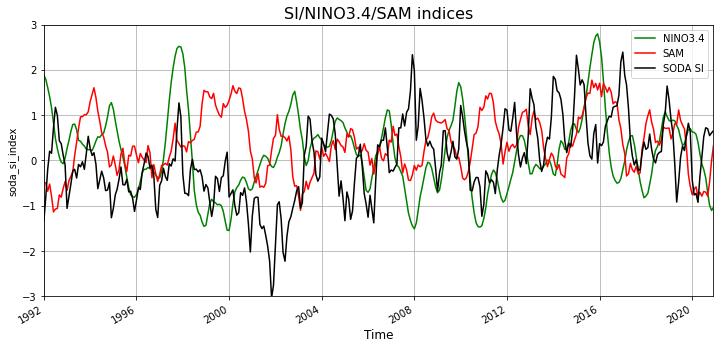

In [9]:
plt.figure(figsize=(12,5))
enso.sel(time=slice('1992', '2020')).plot(color='green', label='NINO3.4')
sam_ms_time.rolling(time=12).mean().plot(color='red', label='SAM') #12mth rolling mean
soda_greg_cal.plot(color='k', label='SODA SI')
plt.legend()
plt.grid()
plt.ylim(-3,3) #ylims with rolling mean
#plt.ylim(-6,6) #ylims without rolling mean
plt.xlim(soda_greg_cal.time[0], soda_greg_cal.time[-1])
plt.title('SI/NINO3.4/SAM indices', fontsize=16)
plt.xlabel('Time', fontsize=12);

## Butterworth filter

In [10]:
from scipy import signal
from scipy import fft

In [11]:
soda_greg_cal

<xarray.DataArray 'soda_si_index' (time: 348)>
array([-1.33993147e+00, -7.94785503e-01, -2.03644555e-01,  2.05115862e-01,
        1.59171354e-01,  7.22375902e-01,  1.17427687e+00,  9.94714389e-01,
        4.35942469e-01,  3.70856318e-01,  1.15204196e-01, -9.42693026e-02,
       -1.05757156e+00, -7.88776431e-01, -5.30667292e-01, -2.31468741e-01,
       -1.94348719e-01, -3.87662078e-01, -8.76037448e-02, -1.39524222e-01,
       -2.80864383e-02, -1.95069978e-01,  1.57666752e-01,  5.34650854e-01,
        2.59702776e-01,  1.10542891e-01,  1.71729629e-01, -7.67074516e-02,
       -6.21807893e-01, -4.29820096e-01, -2.37292101e-01, -3.81615496e-01,
       -6.64409468e-01, -6.53847291e-01, -4.83944787e-01, -1.26323514e+00,
       -1.05956994e+00, -7.56445296e-01, -6.37373457e-01, -4.11171294e-01,
       -1.43123022e-01, -5.33732750e-01, -5.40337933e-01, -4.16486066e-01,
       -6.93409033e-01, -6.80170400e-01, -8.33246122e-01, -1.12395735e+00,
       -8.74883833e-01, -5.93617654e-01, -6.40441376e-01, -2.57507873e-01,
       -6.76120951e-02,  1.64422649e-01,  9.12903783e-02, -1.62607287e-01,
       -1.02075826e-01, -3.55680266e-01, -1.08262477e+00, -1.25885210e+00,
       -5.48723561e-01, -4.46163304e-01, -1.71458490e-01, -3.55403428e-01,
       -4.39283290e-01, -7.24880337e-02, -1.22517630e-01,  3.72509436e-02,
       -1.17742132e-02,  6.92825970e-01,  1.27158085e+00,  9.68655942e-01,
       -3.04880790e-01, -7.23065921e-01, -7.28439403e-01, -7.75645458e-01,
       -1.97152768e-01,  2.65423908e-02, -2.01257230e-01, -1.91708243e-01,
...
        1.35207058e+00,  1.01501794e+00,  4.36427560e-01,  1.74257687e-01,
        3.83417724e-01,  2.93712694e-01,  6.57837192e-01,  1.41037485e+00,
        2.32320342e+00,  2.00814029e+00,  1.66783777e+00,  1.78099550e+00,
        1.67660347e+00,  9.89576631e-01,  3.93853751e-01,  1.04109657e-01,
        3.03160096e-02,  5.91708022e-01,  7.91465774e-01, -5.58883021e-02,
        3.70630615e-01,  3.28305288e-01,  4.07528321e-01,  7.55082819e-01,
        8.73565772e-01,  9.77846679e-01,  9.58522489e-01,  1.17385323e+00,
        1.19626611e+00,  1.21009461e+00,  1.44317345e+00,  2.17660748e+00,
        2.39263697e+00,  1.87636552e+00,  1.67046089e+00,  1.14467100e+00,
        4.33265567e-01,  9.85548984e-02, -9.93253062e-02,  1.51901330e-02,
       -2.11469962e-01, -2.05379476e-01,  1.63066063e-01,  4.08128786e-01,
        2.44884197e-01,  2.86446851e-01,  5.83400599e-01,  2.46097994e-01,
        3.28010741e-02, -5.38036255e-02,  1.24971063e-01,  1.79192753e-01,
        1.96715053e-01,  7.86474334e-01,  1.05354199e+00,  1.64328676e+00,
        1.33754962e+00,  9.00098877e-01,  6.13842454e-01, -8.12300544e-02,
       -9.17353676e-01, -4.74766255e-01,  6.80584393e-02,  3.17885833e-01,
        2.18939365e-01,  5.52416792e-01,  8.22197257e-01,  6.35022945e-01,
       -4.28129943e-01, -7.61256093e-01, -7.27139719e-01, -9.23325841e-01,
       -3.64100745e-01,  6.82412539e-02,  5.27456715e-01,  7.21855892e-01,
        7.02181240e-01,  5.49043420e-01,  6.08854203e-01,  6.59052738e-01])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2020-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [13]:
filt_soda = signal.sosfilt(signal.butter(3, (1/5), output='sos'), soda_greg_cal)
filt_soda.shape

(348,)

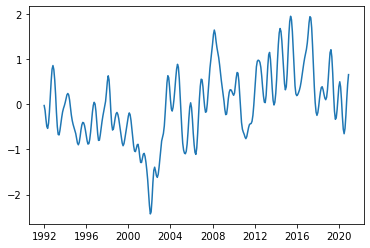

In [14]:
plt.plot(soda_greg_cal.time, filt_soda) #SUCCESS - took out high-freq stuff

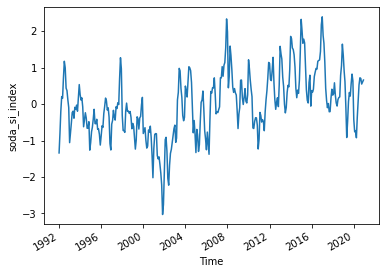

In [15]:
soda_greg_cal.plot()

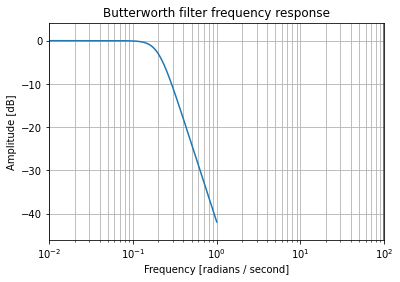

In [16]:
#This is what your filter looks like with inputs 3, (1/5)
b, a = signal.butter(3, (1/5), 'low', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

In [20]:
soda_greg_cal.time

<xarray.DataArray 'time' (time: 348)>
array(['1992-01-01T00:00:00.000000000', '1992-02-01T00:00:00.000000000',
       '1992-03-01T00:00:00.000000000', ..., '2020-10-01T00:00:00.000000000',
       '2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2020-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 80931.]
    _ChunkSizes:      1

In [24]:
sam_ms_time.sel(time=slice('1992', '2020'))

<xarray.DataArray (time: 348)>
array([-0.217692, -1.573846, -1.094462, ...,  1.767031,  1.161406,  2.12625 ])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2020-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [25]:
enso.sel(time=slice('1992', '2020'))

<xarray.DataArray 'sst' (time: 348)>
array([ 1.883747,  1.786449,  1.614739, ..., -0.988256, -1.101873, -1.036802],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2020-12-01
    month    (time) int64 ...

In [26]:
filt_sam = signal.sosfilt(signal.butter(3, (1/5), output='sos'), sam_ms_time.sel(time=slice('1992', '2020')))
filt_enso = signal.sosfilt(signal.butter(3, (1/5), output='sos'), enso.sel(time=slice('1992', '2020')))

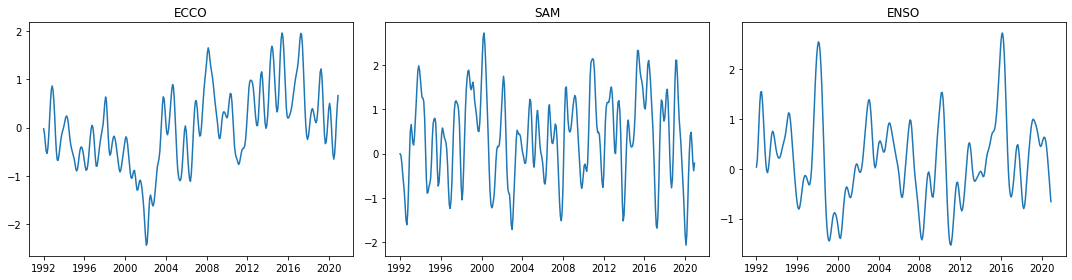

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))

ax[0].plot(soda_greg_cal.time, filt_soda)
ax[0].set_title('ECCO')
ax[1].plot(soda_greg_cal.time, filt_sam)
ax[1].set_title('SAM')
ax[2].plot(soda_greg_cal.time, filt_enso)
ax[2].set_title('ENSO')
plt.tight_layout();

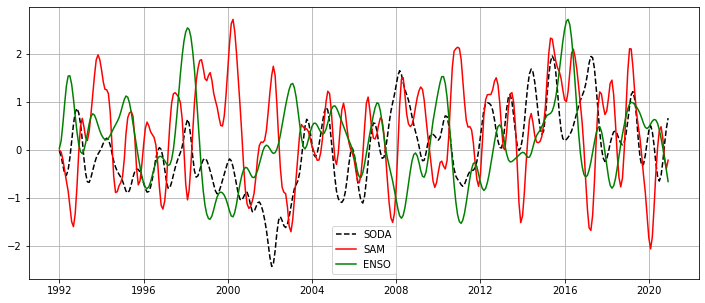

In [28]:
plt.figure(figsize=(12,5))
plt.plot(soda_greg_cal.time, filt_soda, color='k', label='SODA', linestyle='--')
plt.plot(soda_greg_cal.time, filt_sam, color='r', label='SAM')
plt.plot(soda_greg_cal.time, filt_enso, color='g', label='ENSO')
plt.legend()
plt.grid();

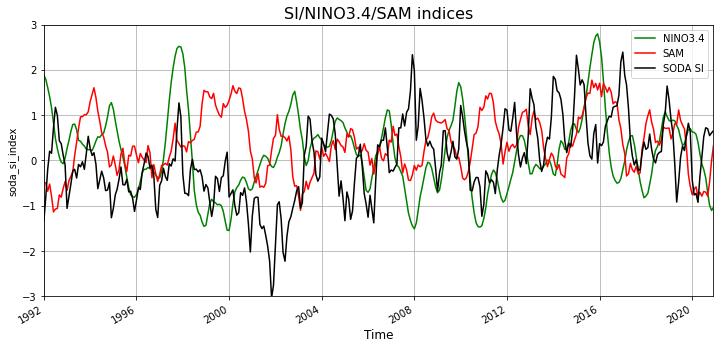

In [9]:
plt.figure(figsize=(12,5))
enso.sel(time=slice('1992', '2020')).plot(color='green', label='NINO3.4')
sam_ms_time.rolling(time=12).mean().plot(color='red', label='SAM') #12mth rolling mean
soda_greg_cal.plot(color='k', label='SODA SI')
plt.legend()
plt.grid()
plt.ylim(-3,3) #ylims with rolling mean
#plt.ylim(-6,6) #ylims without rolling mean
plt.xlim(soda_greg_cal.time[0], soda_greg_cal.time[-1])
plt.title('SI/NINO3.4/SAM indices', fontsize=16)
plt.xlabel('Time', fontsize=12);